In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt 
from sklearn.preprocessing import MinMaxScaler 
from sklearn.model_selection import TimeSeriesSplit

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.dates as mdates  
from sklearn import linear_model

from keras.models import Sequential 
from keras.layers import Dense  
import keras.backend as K 
from keras.callbacks import EarlyStopping  
from keras.optimizers import Adam 
from keras.models import load_model 
from keras.layers import LSTM  
from keras.utils import plot_model

# Package for additional features
from talib import abstract as ta
from talib import RSI
from talib import MACD

# Fine tuning
from sklearn.model_selection import GridSearchCV
from keras.callbacks import EarlyStopping
from keras.layers import Dropout, BatchNormalization



In [2]:
# Define the ticker symbol for the company (e.g., Apple Inc. with the symbol AAPL)
ticker_symbol = "AAPL"

start_date = "2010-01-01"
end_date = datetime.today().strftime('%Y-%m-%d')

data = yf.download(ticker_symbol, start=start_date, end=end_date)

df = pd.DataFrame(data)
print(df.head())

[*********************100%%**********************]  1 of 1 completed
                Open      High       Low     Close  Adj Close     Volume
Date                                                                    
2010-01-04  7.622500  7.660714  7.585000  7.643214   6.470743  493729600
2010-01-05  7.664286  7.699643  7.616071  7.656429   6.481929  601904800
2010-01-06  7.656429  7.686786  7.526786  7.534643   6.378827  552160000
2010-01-07  7.562500  7.571429  7.466071  7.520714   6.367032  477131200
2010-01-08  7.510714  7.571429  7.466429  7.570714   6.409362  447610800


<Axes: xlabel='Date'>

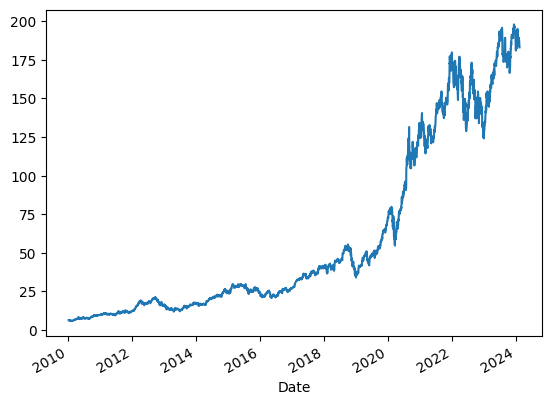

In [3]:
df["Adj Close"].plot()

In [4]:
# Relative Strength Index (RSI): price movement over a given period.
df['RSI'] = RSI(df['Close'], timeperiod=14)

In [5]:
# Moving Average Convergence Divergence (MACD): Identifies trend strength and potential turning points.
macd, signal, hist = MACD(df['Adj Close'], fastperiod=12, slowperiod=26, signalperiod=9)
df['MACD'] = macd
# df['Signal'] = signal
# df['MACD_Hist'] = hist

In [6]:
# Average True Range (ATR): Measures market volatility.
# Higher ATR values indicate higher market volatility, meaning prices are fluctuating more significantly.
# Lower ATR values indicate lower volatility, suggesting a calmer market with smaller price swings.
# You can use ATR to set stop-loss orders, manage risk, and identify potential trading opportunities based on volatility changes.

close_prices = df["Adj Close"]
high_prices = df["High"]
low_prices = df["Low"]

true_range = pd.Series(
    [max(hi - lo, abs(hi - close_prev), abs(lo - close_prev))
     for hi, lo, close_prev in zip(high_prices, low_prices, close_prices.shift(1))]
)

# Higher -> less sensitive to recent data change 
# Lower -> More sensitive to recent data cahange
# 14: Common window size, which can balance. 
window = 14
atr = true_range.rolling(window=window).mean()

atr_df = pd.DataFrame({'ATR': atr.values}, index=df.index)

# Merge the original DataFrame with the new ATR DataFrame
df = pd.merge(df, atr_df, left_index=True, right_index=True)

In [7]:
# Re-order the data frame

# new_order = ["Open", "High", "Low", "Volume", "RSI", 'MACD', 'Signal',
#        'MACD_Hist', "ATR", "Adj Close"]

new_order = ["Open", "High", "Low", "Volume", "Adj Close"]
df = df[new_order]
df

,Open,High,Low,Volume,Adj Close
Date,,,,,
2010-01-04,7.622500,7.660714,7.585000,493729600,6.470743
2010-01-05,7.664286,7.699643,7.616071,601904800,6.481929
2010-01-06,7.656429,7.686786,7.526786,552160000,6.378827
2010-01-07,7.562500,7.571429,7.466071,477131200,6.367032
2010-01-08,7.510714,7.571429,7.466429,447610800,6.409362
...,...,...,...,...,...
2024-02-12,188.419998,188.669998,186.789993,41781900,187.149994
2024-02-13,185.770004,186.210007,183.509995,56529500,185.039993
2024-02-14,185.320007,185.529999,182.440002,54630500,184.149994


In [8]:
# Drop null values 
df.dropna(inplace=True)


In [9]:
#Set Target Variable
output_var = pd.DataFrame(df["Adj Close"])

#Selecting the Features
# features = ["Open", "High", "Low", "Volume", "RSI", 'MACD', "ATR"]
features = ["Open", "High", "Low", "Volume"]


In [10]:
#Scaling
scaler = MinMaxScaler()
feature_transform = scaler.fit_transform(df[features])
feature_transform = pd.DataFrame(data=feature_transform, columns=features, index=df.index)
feature_transform.head()

,Open,High,Low,Volume
Date,,,,
2010-01-04,0.003935,0.003430,0.004155,0.253600
2010-01-05,0.004153,0.003632,0.004319,0.311802
2010-01-06,0.004112,0.003565,0.003849,0.285038
2010-01-07,0.003621,0.002967,0.003530,0.244669
2010-01-08,0.003350,0.002967,0.003532,0.228786


In [11]:
#Splitting to Training set and Test set
timesplit= TimeSeriesSplit(n_splits=10)
for train_index, test_index in timesplit.split(feature_transform):
        X_train, X_test = feature_transform[:len(train_index)], feature_transform[len(train_index): (len(train_index)+len(test_index))]
        y_train, y_test = output_var[:len(train_index)].values.ravel(), output_var[len(train_index): (len(train_index)+len(test_index))].values.ravel()

In [12]:
# Convert the data for LSTM
trainX = np.array(X_train)
testX = np.array(X_test)
X_train = trainX.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = testX.reshape(X_test.shape[0], 1, X_test.shape[1])

In [13]:
# early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

#Building the LSTM Model
lstm = Sequential()
lstm.add(LSTM(32, input_shape=(1, trainX.shape[1]), activation='relu', return_sequences=False))
lstm.add(Dense(1))
lstm.compile(loss='mean_squared_error', optimizer='adam')
plot_model(lstm, show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [14]:
# Train the model 

history=lstm.fit(X_train, y_train, epochs=100, batch_size=8, verbose=1, shuffle=False)
# history = lstm.fit(X_train, y_train, epochs=100, batch_size=8, verbose=1, shuffle=False, 
                   # validation_data=(X_test, y_test), 
                   # callbacks=[early_stopping])


Epoch 1/100
404/404 [==============================] - 1s 636us/step - loss: 2829.6450
Epoch 2/100
404/404 [==============================] - 0s 623us/step - loss: 1459.2299
Epoch 3/100
404/404 [==============================] - 0s 616us/step - loss: 686.6006
Epoch 4/100
404/404 [==============================] - 0s 613us/step - loss: 362.4536
Epoch 5/100
404/404 [==============================] - 0s 615us/step - loss: 213.5384
Epoch 6/100
404/404 [==============================] - 0s 617us/step - loss: 108.4261
Epoch 7/100
404/404 [==============================] - 0s 614us/step - loss: 40.7495
Epoch 8/100
404/404 [==============================] - 0s 616us/step - loss: 11.8043
Epoch 9/100
404/404 [==============================] - 0s 618us/step - loss: 3.9054
Epoch 10/100
404/404 [==============================] - 0s 630us/step - loss: 2.5709
Epoch 11/100
404/404 [==============================] - 0s 625us/step - loss: 2.2610
Epoch 12/100
404/404 [==============================] - 0s

In [15]:
# Make prediction

y_pred= lstm.predict(X_test)

11/11 [==============================] - 0s 600us/step


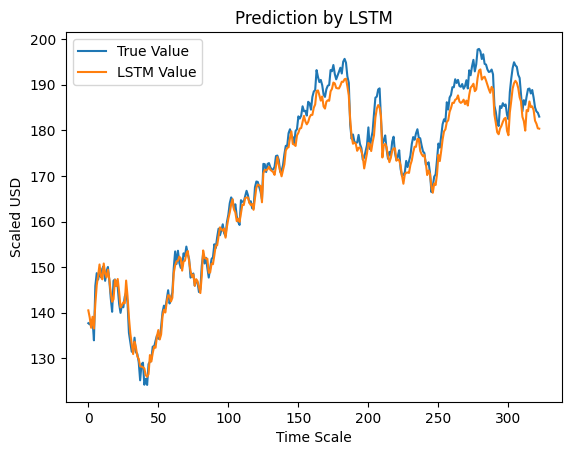

In [16]:
#Predicted vs True Adj Close Value – LSTM

plt.plot(y_test, label='True Value')
plt.plot(y_pred, label='LSTM Value')
plt.title('Prediction by LSTM')
plt.xlabel('Time Scale')
plt.ylabel('Scaled USD')
plt.legend()
plt.show()

In [17]:

# Example for Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred)

# Example for Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)

# Example for R-squared
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"R-squared: {r2}")



MAE: 2.081558723567809
MSE: 6.242071242954534
R-squared: 0.9837048875223728


## Model Fine Tuning

In [18]:
# from keras.models import Sequential
# from keras.layers import LSTM, Dense, Dropout
# from keras.optimizers import Adam

# # Function to create the LSTM model
# def create_lstm_model(units=32, dropout_rate=0.0, learning_rate=0.001):
#     model = Sequential()
#     model.add(LSTM(units, input_shape=(1, trainX.shape[1]), activation='relu', return_sequences=False))
#     model.add(Dropout(dropout_rate))
#     model.add(Dense(1))
    
#     optimizer = Adam(learning_rate=learning_rate)
#     model.compile(loss='mean_squared_error', optimizer=optimizer)
    
#     return model

# # Create the LSTM model
# lstm_model = create_lstm_model()

# # Train the model with different hyperparameter values
# history = lstm_model.fit(X_train, y_train, epochs=100, batch_size=8, verbose=1, shuffle=False, validation_data=(X_test, y_test))

# # Evaluate model performance
# val_loss = lstm_model.evaluate(X_test, y_test)

# # Print the validation loss
# print(f'Validation Loss: {val_loss}')

# # Visualize training and validation loss curves
# plt.plot(history.history['loss'], label='Train')
# plt.plot(history.history['val_loss'], label='Validation')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()
# plt.show()


In [19]:
# y_pred = lstm_model.predict(X_test)

# # Calculate MAE, MSE, and R-squared
# mae = mean_absolute_error(y_test, y_pred)
# mse = mean_squared_error(y_test, y_pred)
# rsquared = r2_score(y_test, y_pred)

# # Print the results
# print(f'Mean Absolute Error (MAE): {mae}')
# print(f'Mean Squared Error (MSE): {mse}')
# print(f'R-squared: {rsquared}')

In [20]:
# # Extract the last sequence from X_train
# last_sequence = X_train[-1:]

# # Reshape the last sequence to match the input shape expected by your model
# last_sequence = last_sequence.reshape(1, X_train.shape[1], X_train.shape[2])

# # Make the prediction
# predicted_value = lstm.predict(last_sequence)

# # If you used scaling during training, inverse transform the predicted value
# # predicted_value = scaler.inverse_transform(predicted_value)

# # Print the results
# print("value for today:", df['Adj Close'].iloc[-1])
# print(f"Predicted value for tomorrow: {predicted_value[0, 0]}")
